In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Reproducing PyMC3 ODE_API_introduction

https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/ODE_API_introduction.ipynb

text for the equations taken from this original.  All simulations done with emcee and pyndamics.

In [2]:
from scipy.integrate import odeint

In [3]:
from pyndamics import Simulation
from pyndamics.emcee import *

pyndamics version  0.0.9


# A Differential Equation For Freefall

An object of mass $m$ is brought to some height and allowed to fall freely until it reaches the ground. A differential equation describing the object's speed over time is 

$$ y' = mg - \gamma y $$

The force the object experiences in the downwards direction is $mg$, while the force the object experiences in the opposite direction (due to air resistance) is proportional to how fast the object is presently moving. Let's assume the object starts from rest (that is, that the object's inital velocity is 0).  This may or may not be the case.  To showcase how to do inference on intial conditions, I will first assume the object starts from rest, and then relax that assumption later.

Data on this object's speed as a function of time is shown below.  The data may be noisy because of our measurement tools, or because the object is an irregular shape, thus leading to times during freefall when the object is more/less aerodynamic.  Let's use this data to estimate the proportionality constant for air resistance.



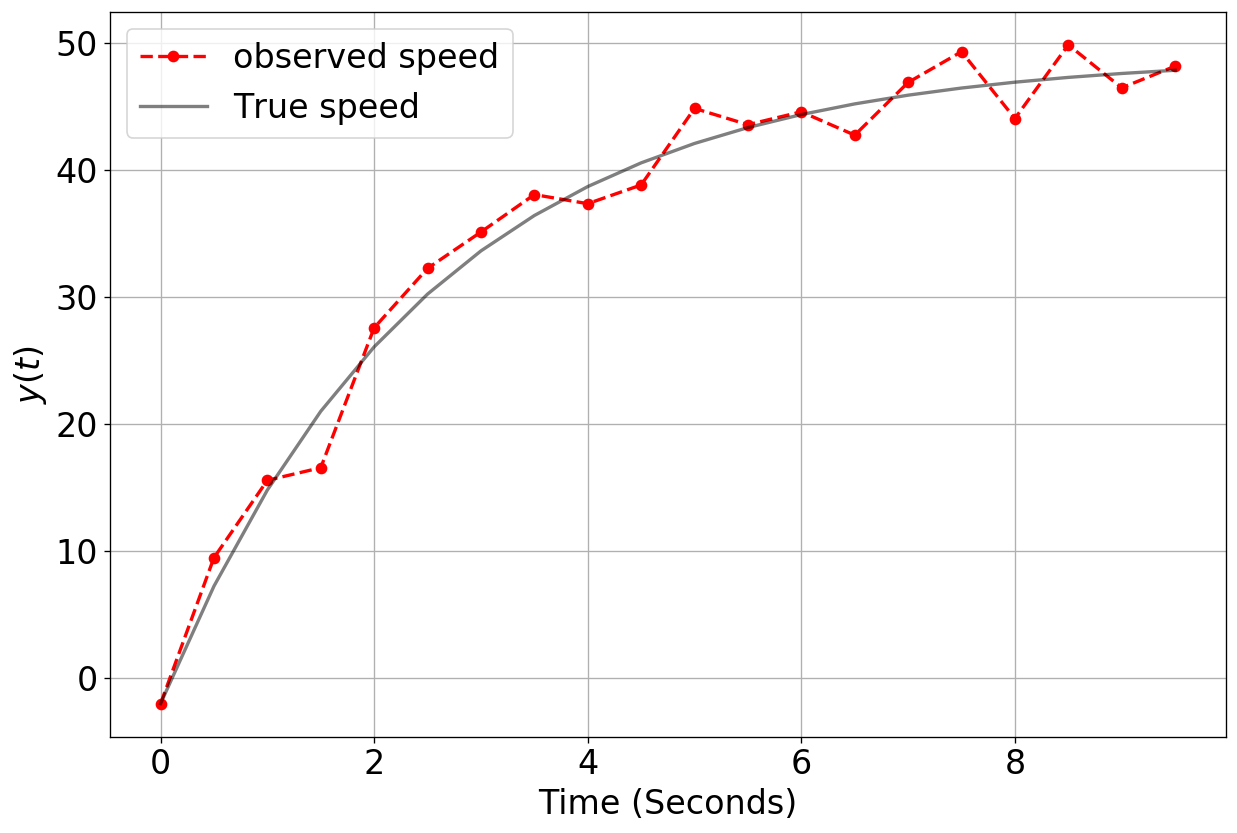

In [4]:
# For reproducibility
np.random.seed(20394)

def freefall(y, t, p):    
    return 2.0*p[1] - p[0]*y[0]

# Times for observation
times = np.arange(0,10,0.5)
gamma,g, y0, sigma = 0.4, 9.8, -2, 2
y = odeint(freefall, t=times, y0=y0, args=tuple([[gamma,g]]))
yobs = np.random.normal(y,2)

fig, ax = plt.subplots(dpi=120)
plt.plot(times,yobs, label='observed speed', linestyle='dashed', marker='o', color='red')
plt.plot(times,y, label='True speed', color='k', alpha=0.5)
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$y(t)$');
plt.show()

```python
ode_model = DifferentialEquation(
    func=freefall,
    times=times,
    n_states=1, n_theta=2,
    t0=0
)

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    sigma = pm.HalfCauchy('sigma',1)    
    gamma = pm.Lognormal('gamma',0,1)

    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=[0], theta=[gamma, 9.8])
    # The ode_solution has a shape of (n_times, n_states)

    Y = pm.Normal('Y', mu=ode_solution, sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)
```

In [5]:
sim=Simulation()
sim.add("y' = m*g - γ*y",0)
sim.params(m=2,g=9.8,γ=0.4)
sim.add_data(t=times,y=yobs)
sim.run(0,10)

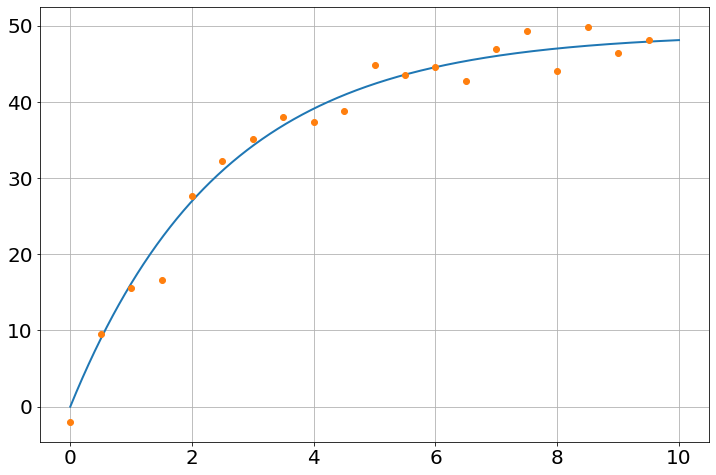

In [6]:
t,y=sim.t,sim.y
plot(t,y)

t,y=sim.components[0].data['t'],sim.components[0].data['value']
plot(t,y,'o')

In [7]:
model=MCMCModel(sim,
                _sigma_y=Uniform(0.1,5),
                γ=Uniform(0,1),
               )

Sampling Prior...
Done.
0.31 s
Running MCMC 1/2...
Done.
22.56 s
Running MCMC 2/2...
Done.
23.13 s


<Figure size 864x576 with 0 Axes>

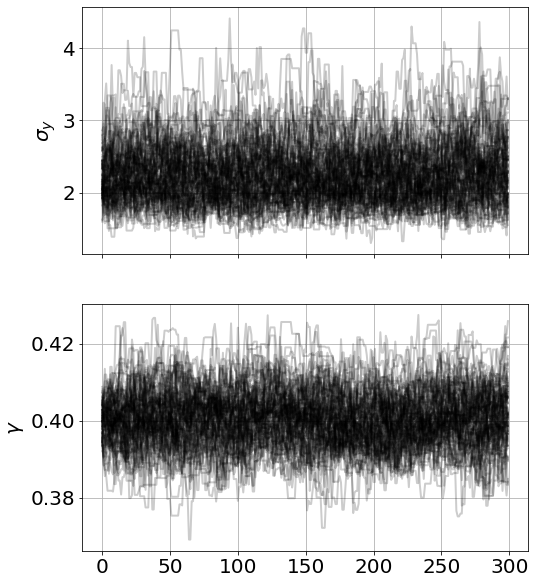

In [8]:
model.run_mcmc(300,repeat=2)
model.plot_chains()

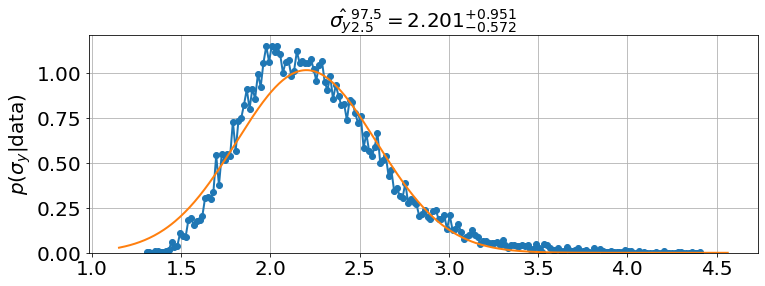

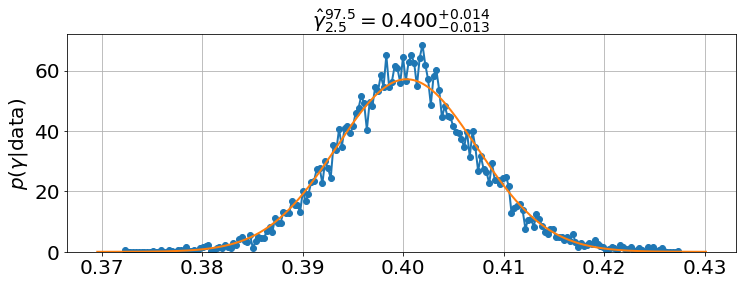

In [9]:
model.plot_distributions()

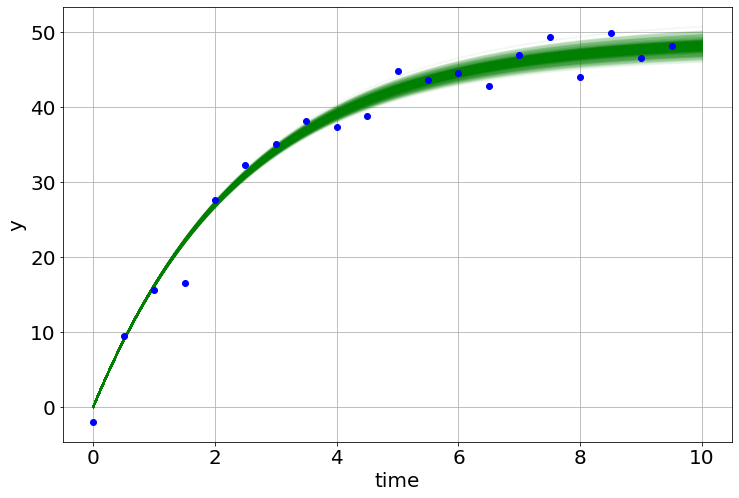

In [10]:
model.plot_many(0,10,'y')

In [11]:
model=MCMCModel(sim,
                _sigma_y=HalfCauchy(1),
                γ=LogNormal(0,1),
               )

Sampling Prior...


/Users/bblais/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
0.78 s
Running MCMC 1/2...
Done.
22.78 s
Running MCMC 2/2...
Done.
22.99 s


<Figure size 864x576 with 0 Axes>

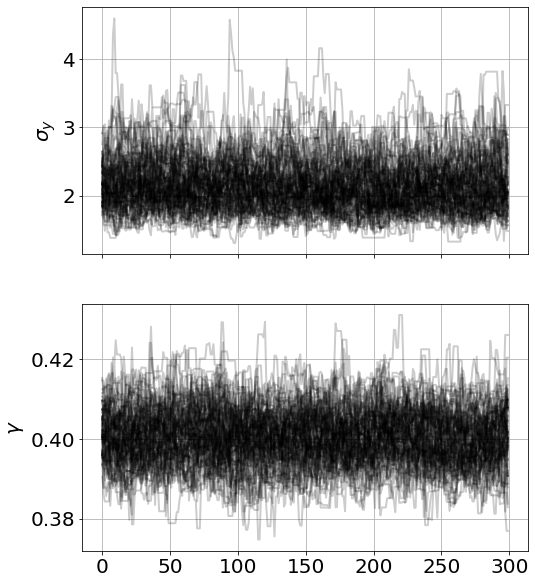

In [12]:
model.run_mcmc(300,repeat=2)
model.plot_chains()

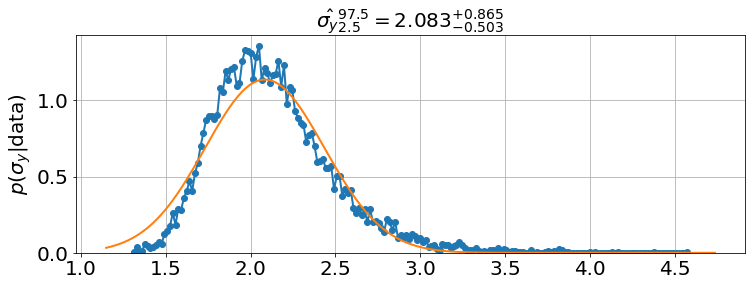

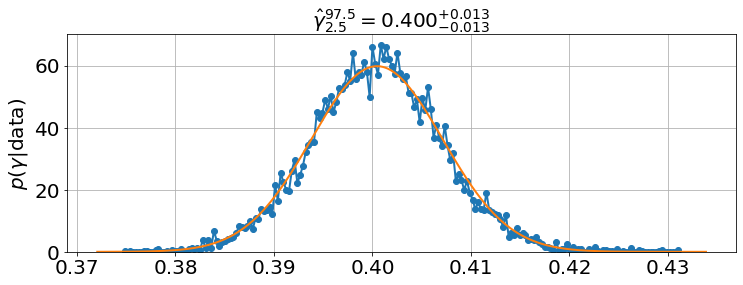

In [13]:
model.plot_distributions()

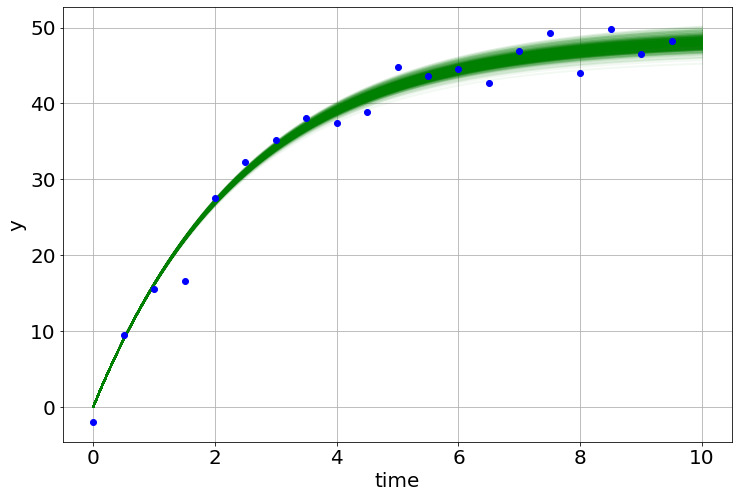

In [14]:
model.plot_many(0,10,'y')

```python
with pm.Model() as model3:    
    sigma = pm.HalfCauchy('sigma',1)
    gamma = pm.Lognormal('gamma',0,1)
    g = pm.Lognormal('g',pm.math.log(10),2)
    # Initial condition prior.  We think it is at rest, but will allow for perturbations in initial velocity.
    y0 = pm.Normal('y0', 0, 2)
    
    ode_solution = ode_model(y0=[y0], theta=[gamma, g])
    
    Y = pm.Normal('Y', mu=ode_solution, sd=sigma, observed=yobs)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)
```

In [15]:
model=MCMCModel(sim,
                γ=LogNormal(0,1),
                g=LogNormal(log(10),2),
                initial_y=Normal(0,2),
               )

Sampling Prior...


/Users/bblais/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
1.28 s
Running MCMC 1/2...
Done.
24.32 s
Running MCMC 2/2...
Done.
23.42 s


<Figure size 864x576 with 0 Axes>

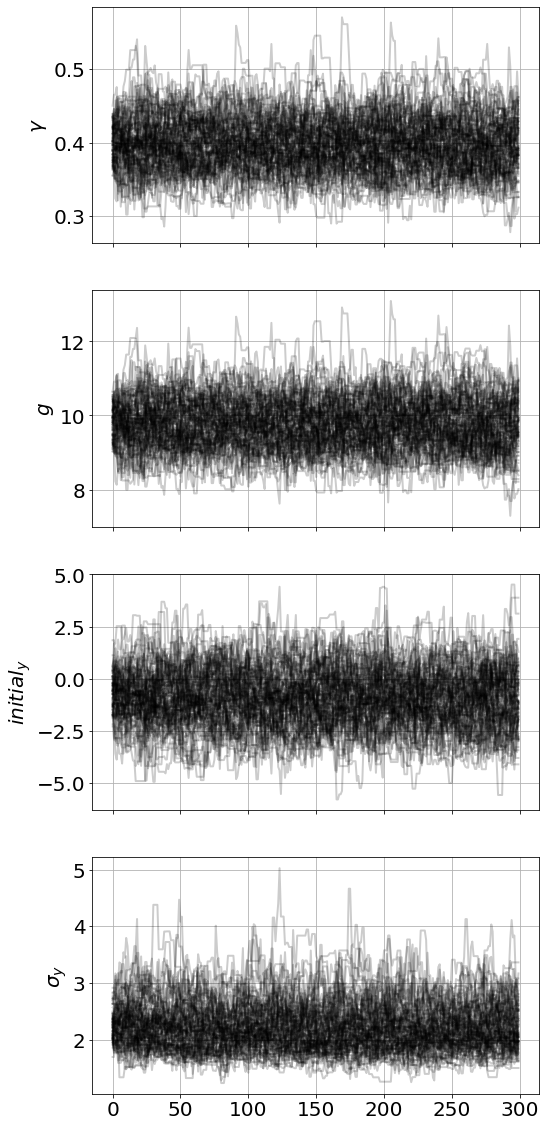

In [16]:
model.run_mcmc(300,repeat=2)
model.plot_chains()

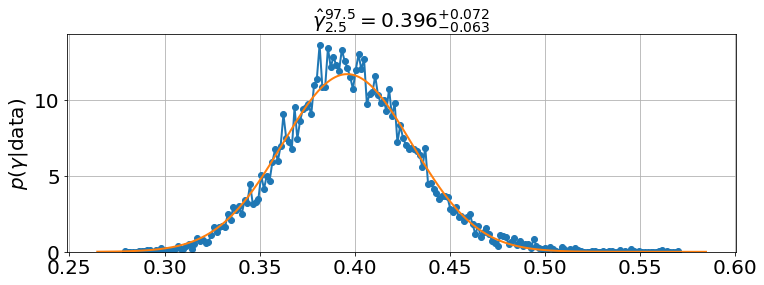

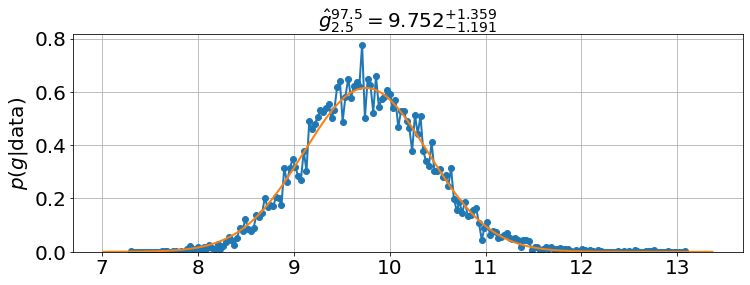

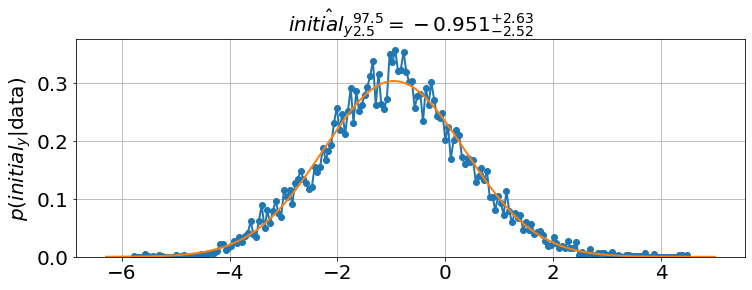

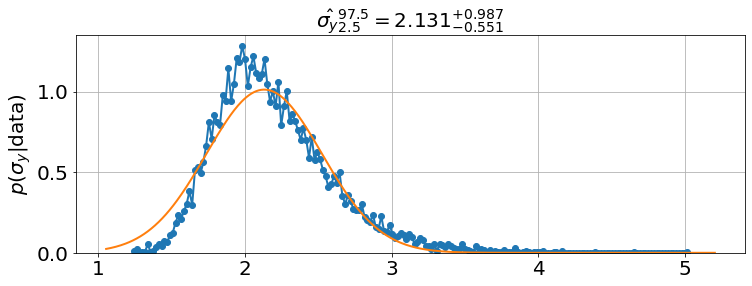

In [17]:
model.plot_distributions()

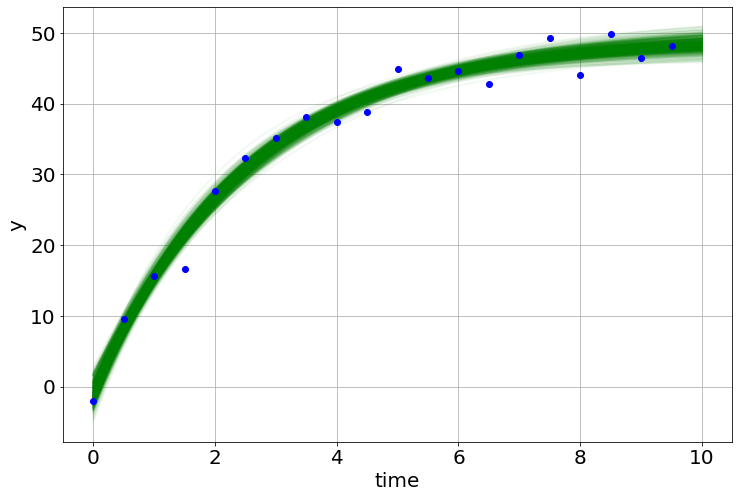

In [18]:
model.plot_many(0,10,'y')

## SIR Model

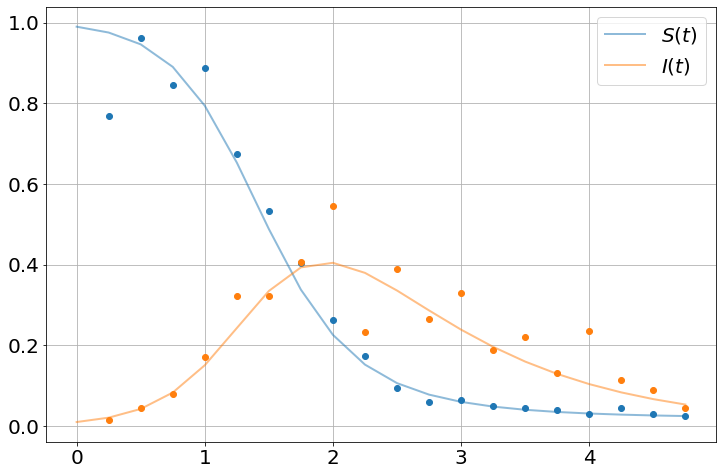

In [19]:
def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]    
    return [ds, di]

times = np.arange(0,5,0.25)

beta,gamma = 4,1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta,gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])


plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

```python
sir_model = DifferentialEquation(
    func=SIR, 
    times=np.arange(0.25, 5, 0.25), 
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model4:    
    sigma = pm.HalfCauchy('sigma', 1, shape=2)
    
    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,3)
    lam = pm.Lognormal('lambda',pm.math.log(2),2)
    beta = pm.Deterministic('beta', lam*R0)
    
    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])
    
    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000,tune=1000, target_accept=0.9, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)
```

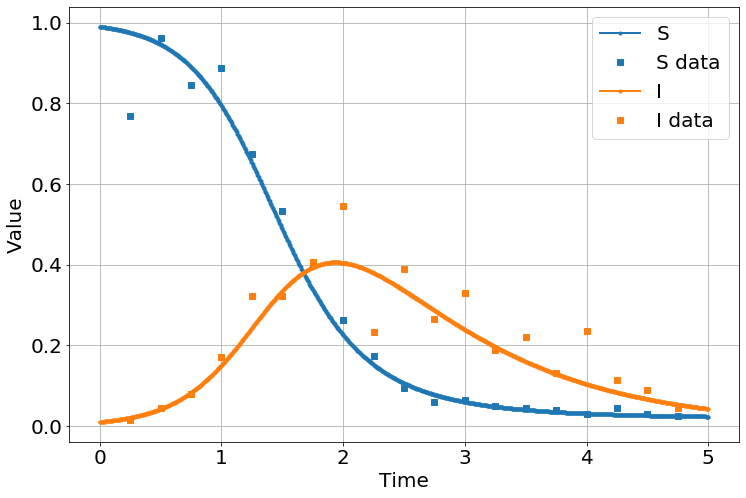

<Figure size 864x576 with 0 Axes>

In [20]:
sim=Simulation()
sim.add("S'= -β*S*I",0.99,plot=1)
sim.add("I'= +β*S*I - γ*I",0.01,plot=1)
sim.params(β=4,γ=1)
sim.add_data(t=times[1:],S=yobs[:,0],plot=1)
sim.add_data(t=times[1:],I=yobs[:,1],plot=1)
sim.run(0,5)

In [21]:
model=MCMCModel(sim,  # _sigma_S and _sigma_I default to Jeffreys
                β=Normal(0,20,all_positive=True),
                γ=Normal(0,20,all_positive=True),
               )

Sampling Prior...


/Users/bblais/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
0.98 s
Running MCMC 1/2...
Done.
27.31 s
Running MCMC 2/2...
Done.
34.10 s


<Figure size 864x576 with 0 Axes>

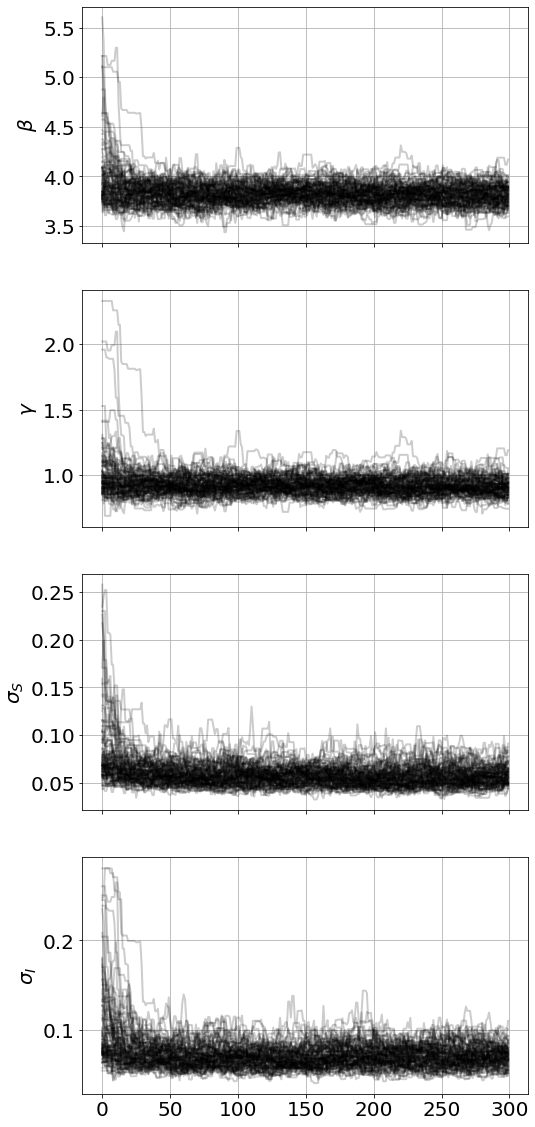

In [22]:
model.run_mcmc(300,repeat=2)
model.plot_chains()

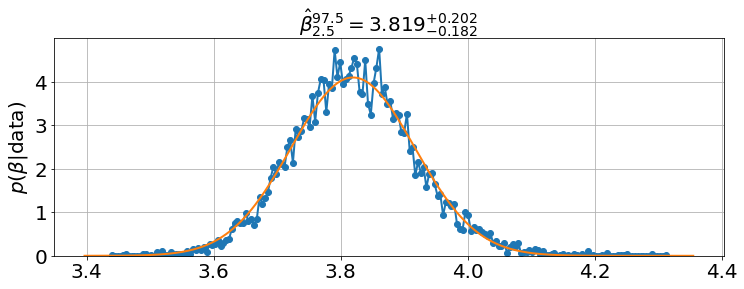

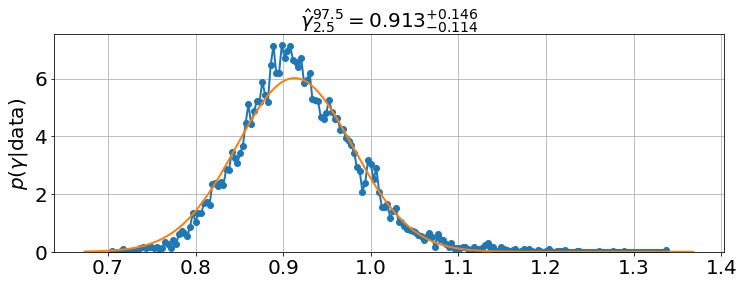

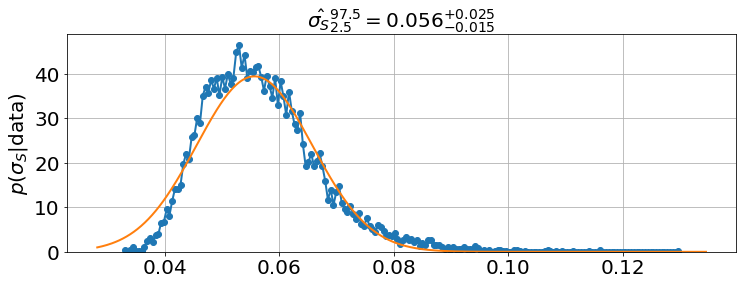

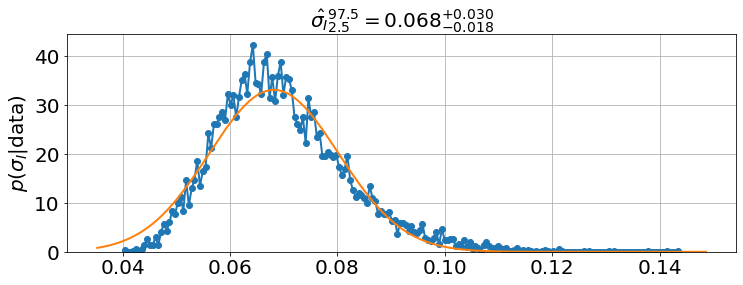

In [23]:
model.plot_distributions()

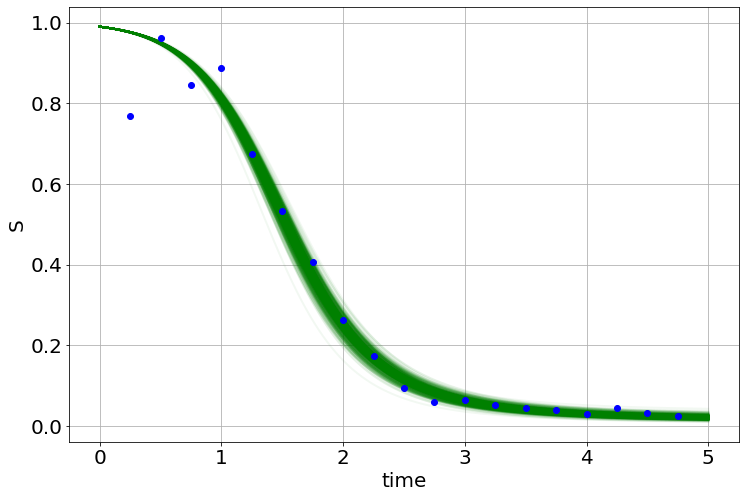

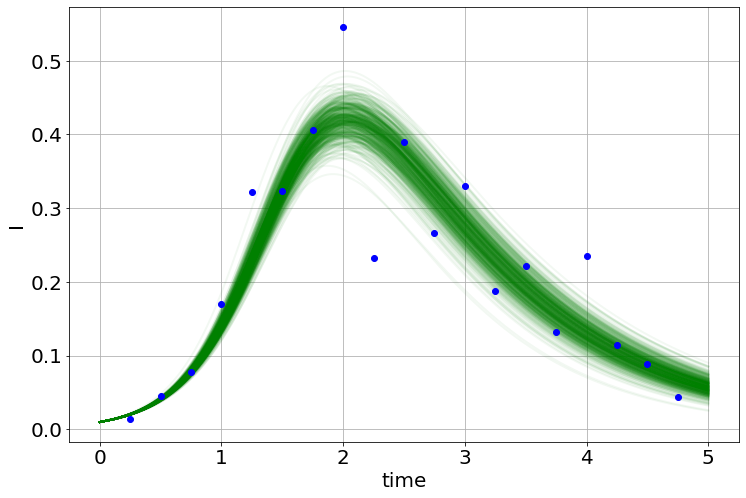

In [24]:
model.plot_many(0,5,['S','I'])

In [25]:
R0=model.eval('β/γ')

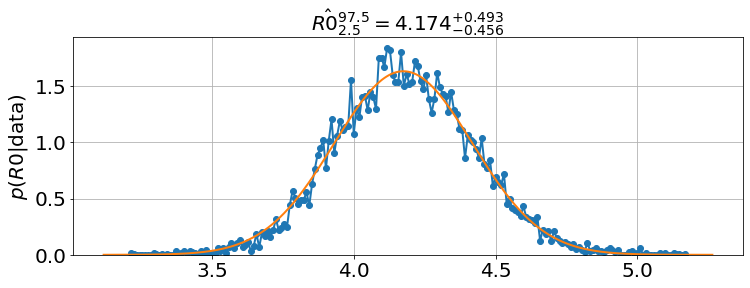

In [26]:
model.plot_distributions(R0=R0)